In [12]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states, run_tdse, run_field_scan
from quantum_tunneling.viz import create_wavefunction_animation
from quantum_tunneling.fields import apply_field
import matplotlib.animation as animation

In [13]:
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 10.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"
state_index = 1
L=30.0
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": L, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
    "tdse": {
        "dt": 0.002,
        "duration": 48.0,
        "record_interval": 25,
        "hbar": 1.0,
        "m": 1.0,
        "F": 2,
        "cap": {"x_start": L-4, "x_end": L-0.5, "strength": 30.0, "power": 2},
    },
}
cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 10.0, 'alpha': 0.5}},
 'grid': {'L': 30.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0},
 'tdse': {'dt': 0.002,
  'duration': 48.0,
  'record_interval': 25,
  'hbar': 1.0,
  'm': 1.0,
  'F': 2,
  'cap': {'x_start': 26.0, 'x_end': 29.5, 'strength': 30.0, 'power': 2}}}

In [14]:
# solve bound states for the given potential(without field)
res = run_bound_states(cfg)

# use the selected bound state as the initial state and run TDSE with the potential + field
td = run_tdse(cfg, res, state_index=state_index)

# results from TDSE simulation

frames = td['frames']
print(f"Total recorded frames: {len(frames)}")

survival = td['survival']
total = td['total']
j1= td['j1']
j2= td['j2']
x1= td['x1']
x2= td['x2']
times = [f['t'] for f in frames]
E = res['E'][state_index]





Total recorded frames: 961


In [15]:
print(f"Selected state energy: E = {E:.4f}")
print(f"Flux at x1={x1:.2f}: j1 = {j1[-1]:.31f}")
print(f"Flux at x2={x2:.2f}: j2 = {j2[-1]:.31f}")

Selected state energy: E = 10.0672
Flux at x1=1.95: j1 = 0.0383897651225060462798488458702
Flux at x2=12.98: j2 = 0.0000354456108230921833400321741


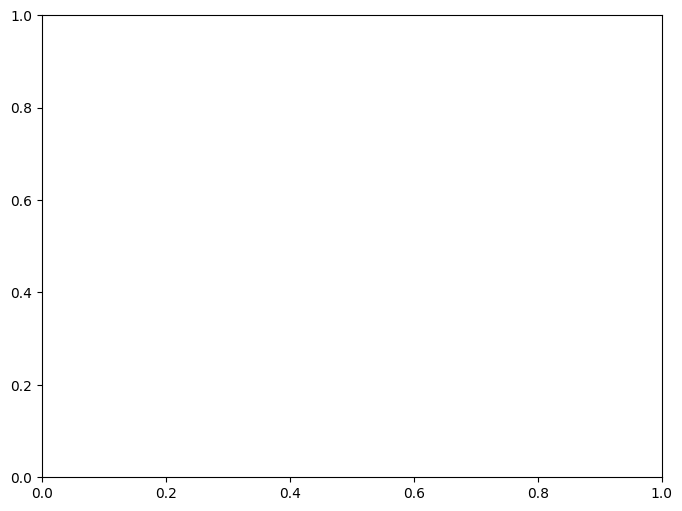

In [16]:
# Create animation
x = res['x']
Vx = res['Vx']
Vtilt = apply_field(Vx, x, cfg['tdse']['F'])
fig, ax = plt.subplots(figsize=(8, 6))
scale = 40
def update(frame):
    ax.clear()
    ax.set_title(f'Time: {frame["t"]:.3f} | Field: {cfg["tdse"]["F"]}')
    ax.plot(x, Vtilt, 'k-', label='Tilted Potential')
    ax.axhline(E, color='r', linestyle='--', label='Bound State Energy')
    ax.axhline(E+scale, color='gray', linestyle=':', label='scale reference "1"')
    
    psi = frame['psi']
    prob_density = np.abs(psi)**2
    psi_real = np.real(psi)
    ax.plot(x,E+ psi_real * scale, 'g-', label='Wavefunction (scaled)')
    psi_imag = np.imag(psi)
    ax.plot(x, E + psi_imag * scale, 'm-', label='Wavefunction Imag (scaled)')
    ax.plot(x, E + prob_density * scale, 'b-', label='Probability Density (scaled)')
    
    # draw cap region
    cap = cfg['tdse']['cap']
    ax.axvspan(cap['x_start'], cap['x_end'], color='orange', alpha=0.3, label='Absorbing Cap')
    ax.set_ylim(-25, 50)
    ax.set_xlim(-7, cfg["grid"]["L"])
    ax.set_xlabel('x')
    ax.set_ylabel('Energy / Probability Density')
    ax.legend()
#ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)
#ani.save(f'time_evolution_V0_{potentials[pot_key]["params"]["V0"]}_F_{cfg["tdse"]["F"]}_state_{state_index}.gif', writer='pillow', fps=30)


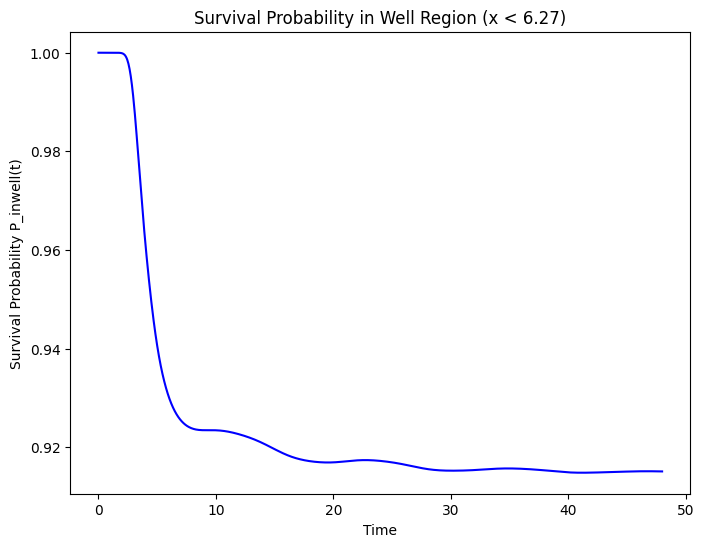

Estimated decay rate from last 960 frames: 0.001034


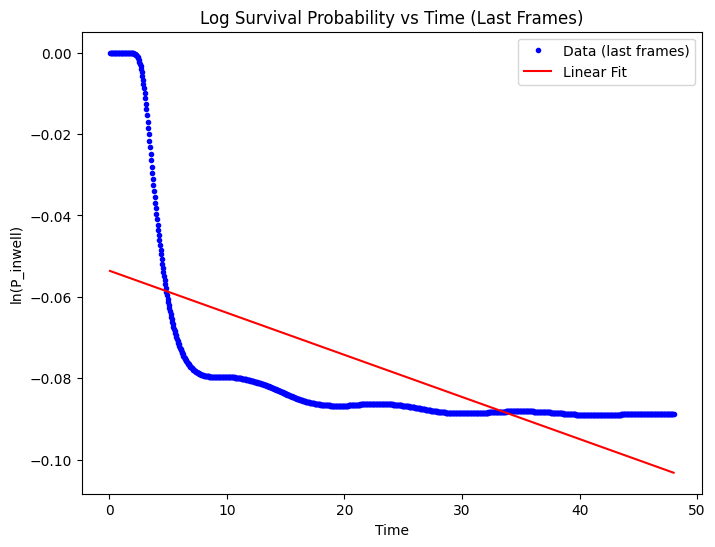

In [19]:
# survival probability is defined by integrating the probability density over the initial well region
# define inwell region as x < x_barrier_top
from quantum_tunneling.fields import barrier_top
x_barrier_top, V_barrier_top, idx_barrier_top = barrier_top(x, Vtilt, xmin=0, xmax=L)
inwell_mask = x < x_barrier_top
inwell_x = x[inwell_mask]
inwell_V = Vtilt[inwell_mask]

# we need inwell Probability as a function of time P_inwell(t)
P_inwell = []
for frame in frames:
    psi = frame['psi']
    prob_density = np.abs(psi)**2
    P_inwell_t = np.trapz(prob_density[inwell_mask], inwell_x)
    P_inwell.append(P_inwell_t)
    
# Plot survival probability over time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(times, P_inwell, 'b-')
ax.set_title(f'Survival Probability in Well Region (x < {x_barrier_top:.2f})')
ax.set_xlabel('Time')
ax.set_ylabel('Survival Probability P_inwell(t)')
plt.show()

# since we are actually using the eigenstate of the static potential as initial
# state, not the eigenstate of the tilted potential, there will be some initial
# drop in survival probability due to this mismatch
# so we can take last few frames to estimate the decay rate
last_n = 960

P_inwell_stable = P_inwell[-last_n:]
times_stable = times[-last_n:]

ln_P = np.log(P_inwell_stable)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(times_stable, ln_P)
decay_rate = -slope
print(f"Estimated decay rate from last {last_n} frames: {decay_rate:.6f}")
plt.figure(figsize=(8,6))
plt.plot(times_stable, ln_P, 'b.', label='Data (last frames)')
plt.plot(times_stable, intercept + slope * np.array(times_stable), 'r-', label='Linear Fit')
plt.title('Log Survival Probability vs Time (Last Frames)')
plt.xlabel('Time')
plt.ylabel('ln(P_inwell)')
plt.legend()
plt.show()


## Notes
- Fit an exponential to `survival` vs time to estimate escape rate Γ.
- Increase `duration` or reduce `dt` for accuracy; ensure CAP starts outside the initial localization region.
- Swap `pot_key` and `F` to probe how exotic shapes tilt and affect escape.